# Visual Search demo

<img src="logo.png" width=350>

## 1. Azure AI Search index creation

This code demonstrates how to use **Azure AI Search** with **Azure AI Vision** and Azure Python SDK for visual search.

## Steps
- Connect to a blob storage where your catalog images are
- Use Azure AI Vision to embed all these images
- Create an Azure AI Search vector store index
- Upload the embeddings into an Azure AI Search index
- Do some visual search using a prompt or an image

## Visual search with vector embeddings
Vector embeddings are a way of representing content such as text or images as vectors of real numbers in a high-dimensional space. These embeddings are often learned from large amounts of textual and visual data using machine learning algorithms like neural networks. Each dimension of the vector corresponds to a different feature or attribute of the content, such as its semantic meaning, syntactic role, or context in which it commonly appears. By representing content as vectors, we can perform mathematical operations on them to compare their similarity or use them as inputs to machine learning models.

## Business applications
- Digital asset management: Image retrieval can be used to manage large collections of digital images, such as in museums, archives, or online galleries. Users can search for images based on visual features and retrieve the images that match their criteria.
- Medical image retrieval: Image retrieval can be used in medical imaging to search for images based on their diagnostic features or disease patterns. This can help doctors or researchers to identify similar cases or track disease progression.
- Security and surveillance: Image retrieval can be used in security and surveillance systems to search for images based on specific features or patterns, such as in, people & object tracking, or threat detection.
- Forensic image retrieval: Image retrieval can be used in forensic investigations to search for images based on their visual content or metadata, such as in cases of cyber-crime.
- E-commerce: Image retrieval can be used in online shopping applications to search for similar products based on their features or descriptions or provide recommendations based on previous purchases.
- Fashion and design: Image retrieval can be used in fashion and design to search for images based on their visual features, such as color, pattern, or texture. This can help designers or retailers to identify similar products or trends.

## Images
In this notebook we took some samples fashion images are taken from this link:<br>
https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

In [2]:
import datetime
import json
import os
import sys
import threading
import time

from azurevisualsearch import delete_index, describe_image, display_image, distribute_image_embedding, get_cosine_similarity, get_image_embedding, get_index_stats, get_index_status, image_embedding, upload_documents, text_embedding, view_search_results
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient, SearchIndexerClient
from azure.search.documents.indexes.models import (
    HnswAlgorithmConfiguration,
    HnswParameters,
    SearchField,
    SearchFieldDataType,
    SearchIndex,
    SearchIndexerDataContainer,
    SearchIndexerDataSourceConnection,
    SimpleField,
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchProfile,
)
from azure.search.documents.models import VectorizedQuery
from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv
from PIL import Image

In [2]:
print(f"Today is {datetime.datetime.now().strftime('%Y-%m-%d')}")

Today is 2025-07-30


In [3]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

## 1. Azure AI Services

In [4]:
load_dotenv("azure.env")

# Azure AI Vision
azure_vision_key = os.getenv("azure_vision_key")
azure_vision_endpoint = os.getenv("azure_vision_endpoint")
api_version = "2024-02-01"
model_version = "2023-04-15"

# Azure AI Search
azure_search_endpoint = os.getenv("azure_search_endpoint")
azure_search_key = os.getenv("azure_search_key")
index_name = "fashion-demo-2025"

# Azure storage account
blob_connection_string = os.getenv("blob_connection_string")
container_name = os.getenv("container_name")

In [5]:
IMAGES_TEST_DIR = "sources"

## 2. Connect to Blob Storage

Retrieve your images from Blob Storage.
All the fashion images are in one blob storage.

In [6]:
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(container_name)
blobs = container_client.list_blobs()
first_blob = next(blobs)
blob_url = container_client.get_blob_client(first_blob).url

print(f"URL of the first blob: {blob_url}")

URL of the first blob: https://azurestorageaccountsr.blob.core.windows.net/fashionimages/fashion/0390469004.jpg


## 3. Connect your Blob Storage to a data source in Azure AI Search

In [7]:
# Create a data source
ds_client = SearchIndexerClient(azure_search_endpoint,
                                AzureKeyCredential(azure_search_key))

container = SearchIndexerDataContainer(name=container_name)

data_source_connection = SearchIndexerDataSourceConnection(
    name=f"{index_name}-blob",
    type="azureblob",
    connection_string=blob_connection_string,
    container=container,
)

data_source = ds_client.create_or_update_data_source_connection(
    data_source_connection)

print(f"✅ Done. Data source: {data_source.name} has been created or updated.")

✅ Done. Data source: fashion-demo-2025-blob has been created or updated.


## 4. Images

In [8]:
number_images = len(list(container_client.list_blobs()))

print(f"✅ Total number of images = {number_images} in container: {container_name}")

✅ Total number of images = 10226 in container: fashionimages


🖼️ Image: fashion/0646756001.jpg


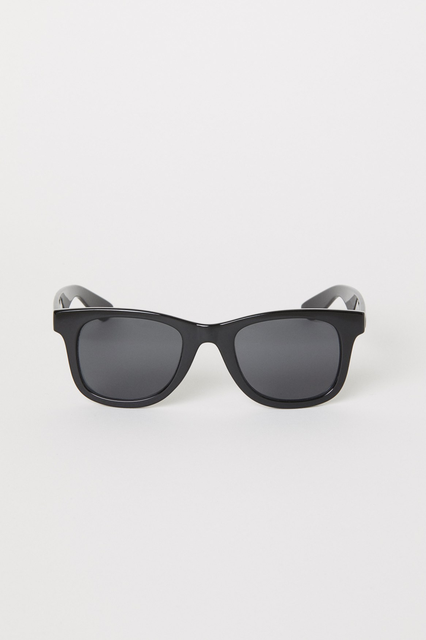

🧠 Automatic analysis of the image using Azure AI Vision:

📝 Main caption:
💬 a pair of sunglasses on a white background = 0.839

Detected tags:
🔖 spectacles = 0.99802
🔖 accessory = 0.99758
🔖 sunglasses = 0.98997
🔖 eyewear = 0.98620
🔖 goggles = 0.97183
🔖 vision care = 0.85773
🔖 aviator sunglass = 0.84280
🔖 glasses = 0.64617
🔖 eyeglasses = 0.52021


In [9]:
image_file = "fashion/0646756001.jpg"

display_image(container_client=container_client, image_file=image_file)
describe_image(container_client=container_client, image_file=image_file)

🖼️ Image: fashion/0627082001.jpg


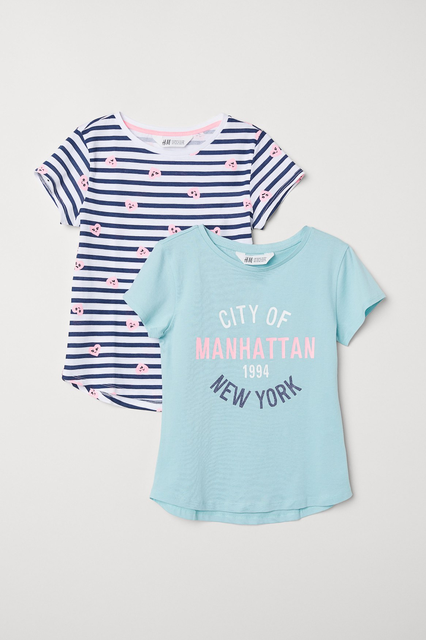

🧠 Automatic analysis of the image using Azure AI Vision:

📝 Main caption:
💬 a pair of shirts on a white background = 0.714

Detected tags:
🔖 clothing = 0.99760
🔖 active shirt = 0.95097
🔖 text = 0.90259
🔖 top = 0.89803
🔖 t-shirt = 0.88811
🔖 shirt = 0.86304
🔖 sleeve = 0.59864


In [10]:
image_file = "fashion/0627082001.jpg"

display_image(container_client=container_client, image_file=image_file)
describe_image(container_client=container_client, image_file=image_file)

## 5. Azure AI Vision embeddings

<img src="https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/media/image-retrieval.png">

### Text Embedding

In [11]:
query = "hello"

text_emb1 = text_embedding(query)
print("Size of the vector embeddings =", len(text_emb1))

Size of the vector embeddings = 1024


In [12]:
query = "hi"

text_emb2 = text_embedding(query)

In [13]:
similarity_score = get_cosine_similarity(text_emb1, text_emb2)
print(f"Cosine similarity = {similarity_score:.05}")

Cosine similarity = 0.95147


### Image embedding

In [14]:
image_file = "fashion/0646756002.jpg"  # location of the image from the blob storage

image_emb1 = image_embedding(image_file)
print("Size of the vector embeddings =", len(image_emb1))

Size of the vector embeddings = 1024


🖼️ Image: fashion/0646756002.jpg


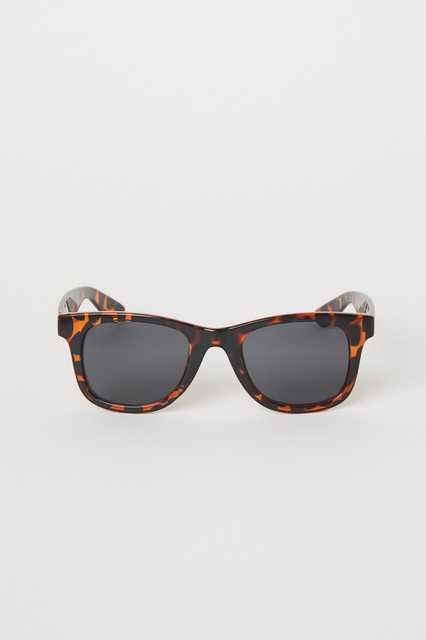

In [15]:
display_image(container_client=container_client, image_file=image_file)

In [16]:
image_file = "fashion/0696732003.jpg"

image_emb2 = image_embedding(image_file)
print("Size of the vector embeddings =", len(image_emb2))

Size of the vector embeddings = 1024


🖼️ Image: fashion/0696732003.jpg


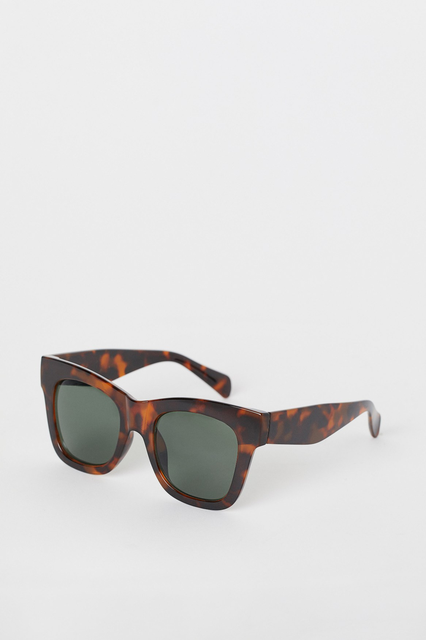

In [17]:
display_image(container_client=container_client, image_file=image_file)

In [18]:
similarity_score = get_cosine_similarity(image_emb1, image_emb2)
print(f"Cosine similarity = {similarity_score:.05}")

Cosine similarity = 0.93929


## 6. Generating the vectors embeddings from our catalog images

In [19]:
EMBEDDINGS_DIR = "embeddings"

os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

In [20]:
list_of_images = container_client.list_blobs()

images_list = []

for image in list_of_images:
    imagefile = image["name"]
    images_list.append(imagefile)

print(f"Number of catalog images = {len(images_list)}")

Number of catalog images = 10226


In [21]:
# Creating a list of catalog images
data = [
    {"idfile": str(i + 1), "imagefile": image} for i, image in enumerate(images_list)
]

json_images_file = os.path.join(EMBEDDINGS_DIR, "list_of_images.json")

with open(json_images_file, "w") as f:
    json.dump(data, f)

!ls $json_images_file -lh

-rwxrwxrwx 1 root root 589K Jul 30 12:34 embeddings/list_of_images.json


### Running the vectors embeddings for all our catalog images

In [22]:
start = time.time()

embeddings_data = distribute_image_embedding(max_workers=2, list_of_files=json_images_file)
print("\n✅ Done")

🏃 Running the image files embeddings with threading...
- Total number of images to embed = 10226
- Using 2 threads

✅ 2025-07-30 12:36:22 Number of processed image files = 001000 of 010226 | Done: 10%
✅ 2025-07-30 12:37:54 Number of processed image files = 002000 of 010226 | Done: 20%
✅ 2025-07-30 12:39:32 Number of processed image files = 003000 of 010226 | Done: 29%
✅ 2025-07-30 12:41:50 Number of processed image files = 004000 of 010226 | Done: 39%
✅ 2025-07-30 12:43:19 Number of processed image files = 005000 of 010226 | Done: 49%
✅ 2025-07-30 12:44:51 Number of processed image files = 006000 of 010226 | Done: 59%
✅ 2025-07-30 12:46:24 Number of processed image files = 007000 of 010226 | Done: 68%
✅ 2025-07-30 12:47:55 Number of processed image files = 008000 of 010226 | Done: 78%
✅ 2025-07-30 12:49:28 Number of processed image files = 009000 of 010226 | Done: 88%
✅ 2025-07-30 12:51:07 Number of processed image files = 010000 of 010226 | Done: 98%
✅ 2025-07-30 12:51:29 Number of pr

In [23]:
elapsed = (time.time() - start)
minutes, seconds = divmod(elapsed, 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")
time_per_image = elapsed / len(images_list)
print(f"Time per image = {time_per_image:.3f} seconds")

Elapsed time = 17 minutes and 14 seconds
Time per image = 0.101 seconds


In [24]:
# Save embeddings to a .json file
start = time.time()

json_output_file = os.path.join(EMBEDDINGS_DIR, "documents.json")
print(f"💾 Saving the results into {json_output_file}...")

with open(json_output_file, "w") as f:
    json.dump(embeddings_data, f)

minutes, seconds = divmod((time.time() - start), 60)
print(f"\n✅ Done. Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds\n")
!ls $json_output_file -lh

💾 Saving the results into embeddings/documents.json...

✅ Done. Elapsed time = 0 minutes and 14 seconds

-rwxrwxrwx 1 root root 119M Jul 30 12:51 embeddings/documents.json


## 7. Creating the Azure AI Search index and uploading the embeddings

In [25]:
try:
    print("⚙️ Setting the Azure AI Search client...")
    search_client = SearchIndexClient(endpoint=azure_search_endpoint, credential=AzureKeyCredential(azure_search_key))
    print("✅ Done")

except:
    print(f"❌ [ERROR] Request failed. Cannot create Azure AI Search client: {azure_search_endpoint}")

⚙️ Setting the Azure AI Search client...
✅ Done


In [26]:
# Deleting any existing index
delete_index(index_name)

🧹 Deleting the Azure AI Search index: fashion-demo-2025
Done


In [27]:
index = SearchIndex(
    name=index_name,
    fields=[
        # Unique ID
        SimpleField(name="idfile", type=SearchFieldDataType.String, key=True),
        # Image filename
        SimpleField(name="imagefile", type=SearchFieldDataType.String),
        # Image embeddings
        SearchField(
            name="imagevector",
            type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
            searchable=True,
            vector_search_dimensions=1024,  # Size of the Azure AI Vision vector embeddings
            vector_search_profile_name="embedding_profile")
    ],
    vector_search=VectorSearch(
        algorithms=[
            HnswAlgorithmConfiguration(
                name="hnsw_config",
                kind=VectorSearchAlgorithmKind.HNSW,
                parameters=HnswParameters(metric="cosine"),  # Use of Cosine Similarity
            )
        ],
        profiles=[
            VectorSearchProfile(name="embedding_profile",
                                algorithm_configuration_name="hnsw_config")
        ]))

In [28]:
search_client.create_index(index)

In [29]:
with open(json_output_file, "r") as file:
    documents = json.load(file)

print(f"🔢 Size of the documents to load = {len(documents)}")

🔢 Size of the documents to load = 10226


In [30]:
print("📤 Loading the vector embeddings into an Azure AI Search index...\n")

start1 = time.time()

idx = 0
total_nb = 0
step = 1
chunk_size = 1000

while idx < len(documents):
    begin = idx
    end = begin + chunk_size
    # Loading the chunck
    chunk_docs = documents[begin:end]
    total_nb += upload_documents(index_name, chunk_docs)
    idx += chunk_size
    step += 1

print(f"🔢 Total number of loaded documents = {total_nb}")

elapsed = time.time() - start1
minutes, seconds = divmod(elapsed, 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")
time_per_image = elapsed / total_nb
print(f"Time per image = {time_per_image:.3f} seconds")

📤 Loading the vector embeddings into an Azure AI Search index...

📤 Uploading the documents into the index fashion-demo-2025...
✅ Uploaded 1000 documents into the Azure AI Search index. Please wait.

📤 Uploading the documents into the index fashion-demo-2025...
✅ Uploaded 1000 documents into the Azure AI Search index. Please wait.

📤 Uploading the documents into the index fashion-demo-2025...
✅ Uploaded 1000 documents into the Azure AI Search index. Please wait.

📤 Uploading the documents into the index fashion-demo-2025...
✅ Uploaded 1000 documents into the Azure AI Search index. Please wait.

📤 Uploading the documents into the index fashion-demo-2025...
✅ Uploaded 1000 documents into the Azure AI Search index. Please wait.

📤 Uploading the documents into the index fashion-demo-2025...
✅ Uploaded 1000 documents into the Azure AI Search index. Please wait.

📤 Uploading the documents into the index fashion-demo-2025...
✅ Uploaded 1000 documents into the Azure AI Search index. Please wai

## 8. Azure AI Search index status

In [5]:
get_index_status(index_name)

Azure AI Search Index: fashion-demo-2025

{
     "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DDCF67D67B39AB\"",
     "name": "fashion-demo-2025",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "idfile",
               "type": "Edm.String",
               "searchable": false,
               "filterable": false,
               "retrievable": true,
               "stored": true,
               "sortable": false,
               "facetable": false,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "dimensions": null,
               "vectorSearchProfile": null,
               "vectorEncoding": null,
               "synonymMaps": []
          },
          {
               "name": "imagefile",
               "type": "Edm.String",
               "searchable": false,
               

In [6]:
document_count, storage_size = get_index_stats(index_name)

📡 Azure AI Search index status for: fashion-demo-2025

{
  "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#Microsoft.Azure.Search.V2024_07_01.IndexStatistics",
  "documentCount": 10226,
  "storageSize": 115931376,
  "vectorIndexSize": 42451784
}


In [7]:
print(f"🔢 Number of documents in the index = {document_count:,}")
print(f"📏 Size of the index = {storage_size / (1024 * 1024):.2f} MB")

🔢 Number of documents in the index = 10,226
📏 Size of the index = 110.56 MB


## 9. Quick tests

In [34]:
search_client = SearchClient(azure_search_endpoint, index_name, AzureKeyCredential(azure_search_key))

### Prompt text exemple

In [35]:
prompt = "I want some Japanese T-shirts, what do you have?"

In [36]:
topn = 6

query_vector = text_embedding(prompt)
request = search_client.search(None,
                               vector_queries=[
                                   VectorizedQuery(vector=query_vector,
                                                   k_nearest_neighbors=topn,
                                                   fields="imagevector")
                               ])

results = [(doc["imagefile"], doc["@search.score"]) for doc in request]

print("\033[1;34m")
print("🔍 Top Image Results (Sorted by Cosine Similarity):\n")

for idx, (filename, score) in enumerate(results, start=1):
    print(f"✅ Top {idx:02}: {filename:<20} | 🔗 Cosine Similarity = {score:.3f}")

print("\033[0m")


🔍 Top Image Results (Sorted by Cosine Similarity):

✅ Top 01: fashion/0625877003.jpg | 🔗 Cosine Similarity = 0.616
✅ Top 02: fashion/0625877006.jpg | 🔗 Cosine Similarity = 0.616
✅ Top 03: fashion/0625877004.jpg | 🔗 Cosine Similarity = 0.613
✅ Top 04: fashion/0699202004.jpg | 🔗 Cosine Similarity = 0.611
✅ Top 05: fashion/0691906001.jpg | 🔗 Cosine Similarity = 0.609
✅ Top 06: fashion/0641748010.jpg | 🔗 Cosine Similarity = 0.607




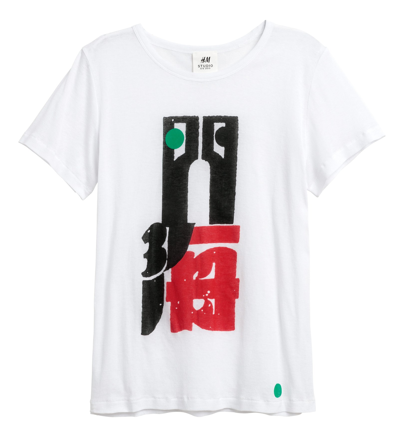
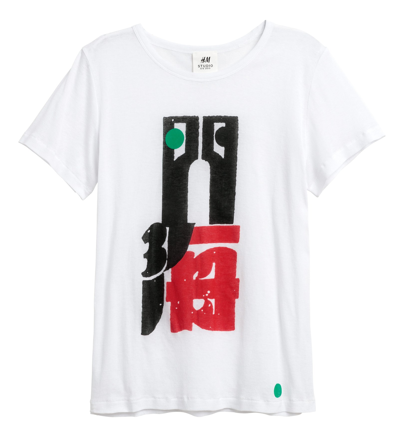
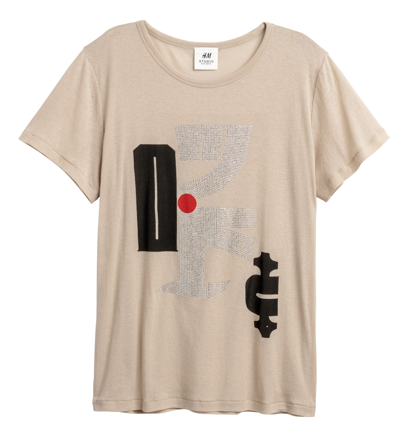
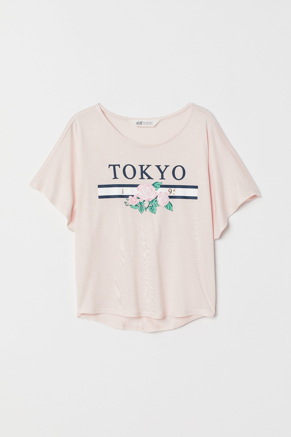
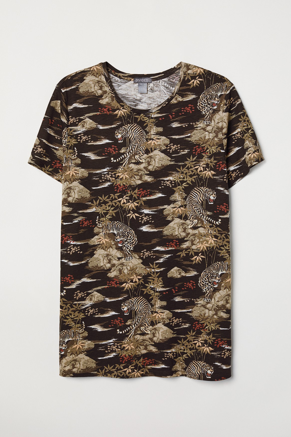
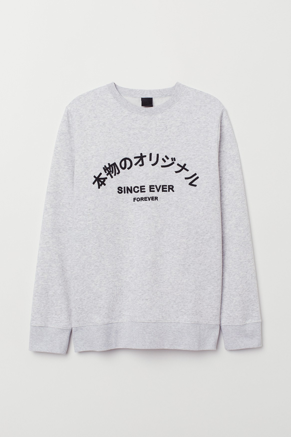

In [37]:
view_search_results(results)

### Image prompt example

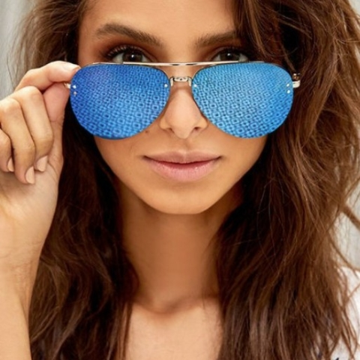

In [38]:
prompt_image = os.path.join(IMAGES_TEST_DIR, "image1.jpg")

img = Image.open(prompt_image).resize((360,360))
img

In [39]:
topn = 6

query_vector = get_image_embedding(prompt_image)

request = search_client.search(None,
                               vector_queries=[
                                   VectorizedQuery(vector=query_vector,
                                                   k_nearest_neighbors=topn,
                                                   fields="imagevector")
                               ])
results = [(doc["imagefile"], doc["@search.score"]) for doc in request]

print("\033[1;34m")
print("🔍 Top Image Results (Sorted by Cosine Similarity):\n")

for idx, (filename, score) in enumerate(results, start=1):
    print(f"✅ Top {idx:02}: {filename:<20} | 🔗 Cosine Similarity = {score:.5f}")

print("\033[0m")


🔍 Top Image Results (Sorted by Cosine Similarity):

✅ Top 01: fashion/0699325004.jpg | 🔗 Cosine Similarity = 0.80350
✅ Top 02: fashion/0647236001.jpg | 🔗 Cosine Similarity = 0.79693
✅ Top 03: fashion/0694669002.jpg | 🔗 Cosine Similarity = 0.79230
✅ Top 04: fashion/0694748001.jpg | 🔗 Cosine Similarity = 0.78844
✅ Top 05: fashion/0625146001.jpg | 🔗 Cosine Similarity = 0.78696
✅ Top 06: fashion/0398959003.jpg | 🔗 Cosine Similarity = 0.78645




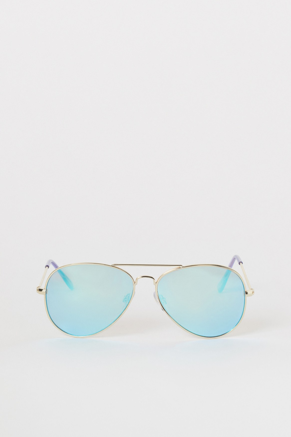
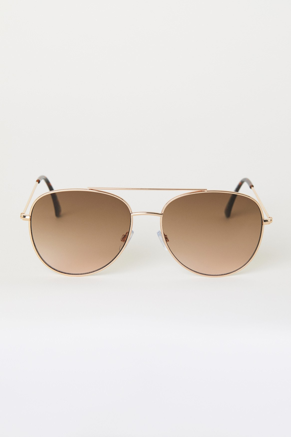
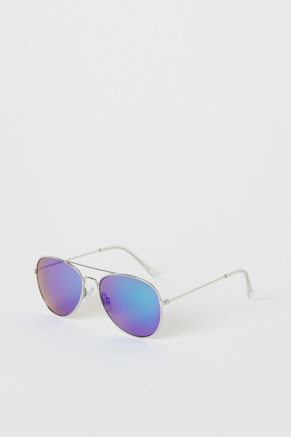
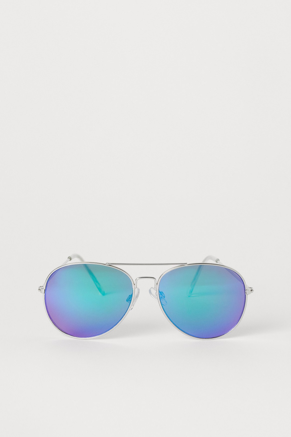
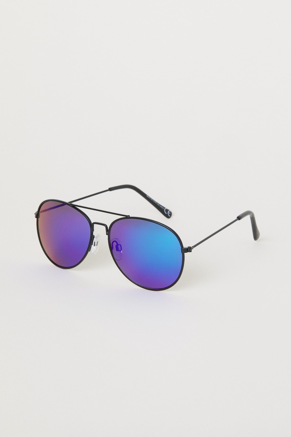
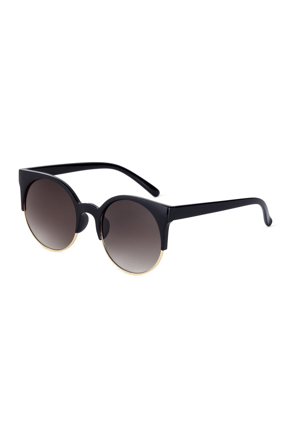

In [40]:
view_search_results(results)

> Go to the next notebook